# Exploring the Blocksci package

In this script we explore some of the functionality of the Blocksci package. We have been able create the following:

>  - Plot the donations over the lifetime of the accounts
>  - Plot the expense over the lifetime of the accounts (altough suspicious)
>  - Create Histogram of how many times people donate if they donate multiple times
>  - Compare the donors of two different accounts and see if people donate to multiple accounts

## To DO:

>  - Get clustering working
>  - Network analysis

In [2]:
"""
Run this to start the script. It contains all the packages and user defined functions needed
"""

import csv
import blocksci
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
import datetime
from collections import Counter
%matplotlib notebook

# Some utility functions 
def get_balances(cluster=None, heights=None):
    """
    Method to compute the balances of a cluster for a given list of block heights.
    """
    return [(int(height), cluster.balance(int(height))) for height in heights]


def get_lifetime(address):
    """
    Method to get the lifetime of a Bitcoin Address which is the difference between the last 
    time the address released a payment and the first time it received a payment. Returns a tuple
    containing the address value, the first / last block time, first / last block height, and the 
    lifetime.
    """
    address_value = address.address_string
    first_block_time = address.first_tx.block_time
    first_block_height = address.first_tx.block_height
    try:
        last_time_block = address.out_txes()[-1].block_time
    except:
        last_time_block = None
    try:
        last_block_height = address.out_txes()[-1].block_height
    except:
        last_block_height = None
    try:
        life_time = address.out_txes()[-1].block_time - address.first_tx.block_time
    except:
        life_time = None
    return (address_value,
            first_block_time,
            first_block_height,
            last_time_block,
            last_block_height,
            life_time)


def get_lifetimes(addresses):
    """
    Method returning a list of tuples containing the lifetime given a list of Bitcoin Addresses. 
    """
    return [get_lifetime(address) for address in addresses]


def get_payments_df(txes, chain):
    """
    Method to compute the amount of received or spent payments in dollars given a list of 
    input or output transactions. It returns a DataFrame indexed by time with payments in 
    USD and the block height as columns. 
    """
    payments = [(tx.block, tx.block_height, tx.input_value, tx.hash, tx.ins, tx.outs) if isinstance(tx, blocksci.Tx)
                else (tx.block, tx.tx.block_height, tx.value, tx.tx.hash, tx.tx.ins, tx.tx.outs) for tx in txes]
    df = pd.DataFrame(payments, columns=["block", "height", "payment", "hash", "inputs", "outs"])
    return get_dollars_df(chain, df, "payment")

def get_dollars_df(chain, df=None, column_name=None):
    df.index = df["height"]
    converter = blocksci.CurrencyConverter()
    df = chain.heights_to_dates(df)
    df["usd"] = df.apply(lambda x: converter.satoshi_to_currency(x[column_name], chain[x["height"]].time), axis=1)
    df.index.name = "date"
    return df


def is_it_in_cluster(cluster=None, seed=None):
    """
    Method to get the size of a cluster. 
    """
    addresses = [address for address in cluster.addresses]
    return seed in addresses


def get_size(cluster=None, limit=10000):
    """
    Method to get the size of a cluster. This method does not count the number of addresses above 
    a certain limit (default: 10000).
    """    
    addresses = []
    iteration = 0
    for address in cluster.addresses:
        if iteration < limit:
            addresses.append(address)
            iteration += 1
        else:
            print("Too many addresses!")
            break
    return len(addresses)


#---------------------------------------------------------------
#Hidde additions

def from_list_strings_to_address(list_of_strings, chain):
    working = []
    for str_address in list_of_strings:
        try:
            block_address = chain.address_from_string(str_address)
            if not block_address == None:
                working.append(block_address)
        except RuntimeError:
            continue
    return working


def get_donors_counter(individual_list, chain):
    transactions = []
    for address in individual_list:
        transactions.append(get_payments_df(address.out_txes(), chain))
    
    transaction_df = pd.concat(transactions)
    donor_list = [tx.address for row in transaction_df['inputs'] for tx in row]
    donor_counter = Counter(donor_list)
    return donor_counter

def get_overlapping(transaction_list_0, transaction_list_1):
    list_0 = set([tx.address for row in transaction_list_0['inputs'] for tx in row])
    list_1 = set([tx.address for row in transaction_list_1['inputs'] for tx in row])
    
    overlapping = []
    overlapping_count = 0
    for address in list_0:
        if address in list_1:
            overlapping.append(address)
            overlapping_count += 1

    return overlapping, overlapping_count


def get_donations(address):
    """
    sometime a transaction is to multiple accounts. We retriece only the relevant amount
    """
    donations_tx = []
    for txs in address.out_txes():
        for tx in txs.outputs:
            if tx.address == address:
                donations_tx.append(tx)
    return donations_tx

def get_cash_out(address):
    """
    sometime a transaction is to multiple accounts. We retriece only the relevant amount
    """
    cash_out_tx = []
    for txs in address.in_txes():
        for tx in txs.inputs:
            if tx.address == address:
                cash_out_tx.append(tx)
    return cash_out_tx

In [3]:
# notes alexis
bitcoin_chain = blocksci.Blockchain("/home/ubuntu/bitcoin")


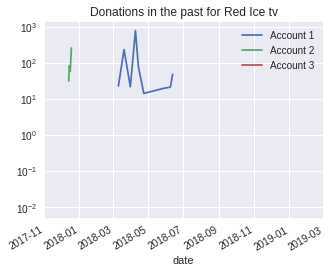

Total donations are: 1656.972881113703


In [6]:
converter = blocksci.CurrencyConverter()


#known addresses
Red_ice_tv_addresses = ["3K8v2891LrWjuBPdSKHkKZmUW9vXTmMrBB",
                        "3FTzT6pRr6ZXnXQwamdSXU7kzFFuzD8uhF",
                        "1NtkDjLLq3tGiEWg5ZnaVD56Vy4rLfZHB7",
                        "15GFG2CVA6Ftq4w7dRuug9CQCsyrpeN1XG",
                        "1BvQUrTD9MiuNXovf6i2oGiBcZyuygsDqs",
                        "1As8nyiVibNzfjLiS1eCinYia2dK2ZgHiz"]

#Check which ones work

working_RICtv = from_list_strings_to_address(Red_ice_tv_addresses, bitcoin_chain)
transactions_RICtv = []
for address in working_RICtv:
    out = get_donations(address)
    transactions_RICtv.append(get_payments_df(out, bitcoin_chain))

        
mpl.style.use('seaborn')

fig = plt.figure(num=1, figsize=(5,4))
ax = transactions_RICtv[0].usd.plot()
transactions_RICtv[1].usd.plot(ax=ax)
transactions_RICtv[2].usd.plot(ax=ax)
ax.set_xlim(datetime.datetime(2017,11,1), datetime.datetime(2019,3,1))
ax.set_yscale('log')
ax.legend(['Account 1',
           'Account 2',
           'Account 3'])

plt.title('Donations in the past for Red Ice tv')

plt.show()

total = sum([transactions.usd.sum() for transactions in transactions_RICtv])

print('Total donations are: {}'.format(total))

Total donations are: 1209451.0942752992


/usr/local/lib/python3.5/dist-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


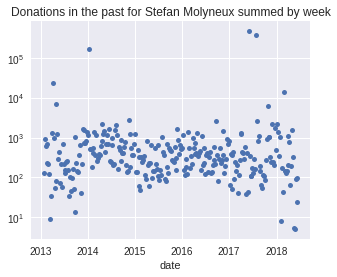

In [5]:
#known addresses
Stefan_addresses = "1Fd8RuZqJNG4v56rPD1v6rgYptwnHeJRWs"

#Check which ones work
working_Stefan = bitcoin_chain.address_from_string(Stefan_addresses)
donations = get_donations(working_Stefan)
transactions_Stefan = get_payments_df(donations, bitcoin_chain)

mpl.style.use('seaborn')

fig = plt.figure(num=2, figsize=(5,4))
y_values = transactions_Stefan.usd.resample('W').sum() 
ax = y_values.plot(marker = "o",
                   linestyle='None',
                    markersize=5)
ax.set_yscale('log')
ax.set_title('Donations in the past for Stefan Molyneux summed by week')

# plt.savefig('Example_donations_stefan.png', format="png")
#Use usd for us dollars
#Use payment for bitcoins

total = transactions_Stefan.usd.sum()
print('Total donations are: {}'.format(total))

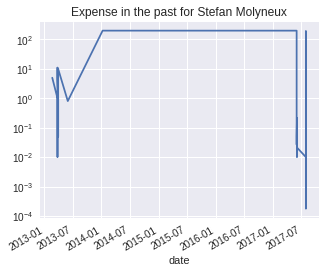

In [7]:
#Now expendatures 

cash_out = get_cash_out(working_Stefan)
expenses_Stefan = get_payments_df(cash_out, bitcoin_chain)

fig = plt.figure(num=3, figsize=(5,4))
y_values = expenses_Stefan.payment / 1e8
ax = y_values.plot()
ax.set_yscale('log')


plt.title('Expense in the past for Stefan Molyneux')

plt.show()

In [8]:
latest_time = transactions_Stefan.index[-1]

df = pd.DataFrame({'Balance':working_Stefan.balance()}, index = [latest_time])
converter.satoshi_to_currency_df(df, bitcoin_chain)

,Balance
2018-06-12 17:49:23,38165.557808


In [ ]:
# cluster_data_directory should be set to the directory containing the
# output of the `clusterer` program
cm = blocksci.cluster.ClusterManager("/home/ubuntu/bitcoin/clusters", bitcoin_chain)

In [ ]:
Stefan_counter = get_donors_counter([working_Stefan], bitcoin_chain)
fig_hist, axes_hist = plt.subplots()
axes_hist.hist(Stefan_counter.values(),bins = range(1,11))

plt.savefig('Histogram_donaters_stefan.png', format='png')

In [ ]:
RICtv_counter =  get_donors_counter(working_RICtv, bitcoin_chain)

n, bins, patches = plt.hist(RICtv_counter.values(),bins = [1, 2, 3, 4, 5])


In [ ]:
print(get_overlapping(transactions_RICtv_all, transactions_Stefan))

In [ ]:
"""
Now we will do the sampe for a bunch of other channels
"""

Millenial_woes = [
                    "1F3iu15DwhPRAyqJF1hMiDESRpxw8psSHk",
                    "1Ac1rdoSgozufd8tkgcCo82XbYiFhFreuy"
]

The_Thinkery   = [
                    "182f686d2cc3817fe8154a8b5183147667", 
                    "1fYE37y6Jv9ymMnfVlezDhS1OhsVhGMtAg",
                    "1FAIpQLSdKt9uvG6PDMzYPzZZSMcFXDLRJ"
]

Count_dankula  = [
                    "18Kgfgpd1PqSiyaxdWzvz3jLaBPYeKDSyL",
                    "15gXKdF7KdjBRQWhE5fqLDbNaUTHwieFh5",
]

FREIE_HEIMAT   = [
                    "1BBSvRovKDNgLjemn5i1kLnzJrNCLjkYeV",
                    "3QM41JzLftN89BmjrcxzYTRV3N2BGGL2h8",
                    "1LeebMVtXGvky19AcoYAzuZaqdEhQe6gzn",
                    "1NRWc4C63jc2EBCSLStWW84wthCfsCSKNW"
]

Millenial_woes_chain = from_list_strings_to_address(Millenial_woes, bitcoin_chain)
The_Thinkery_chain   = from_list_strings_to_address(The_Thinkery, bitcoin_chain)
Count_dankula_chain  = from_list_strings_to_address(Count_dankula, bitcoin_chain)
FREIE_HEIMAT_chain   = from_list_strings_to_address(FREIE_HEIMAT, bitcoin_chain)

#Check if lists are not empty
if not Millenial_woes_chain:
    print('No valid addresses were found for Millenial_woes')
    
if not The_Thinkery_chain:
    print('No valid addresses were found for The_Thinkery')
    
if not Count_dankula_chain:
    print('No valid addresses were found for Count Dankula')
    
if not FREIE_HEIMAT_chain:
    print('No valid addresses were found for FREIE HEIMAT')

#Get donating data
transactions_Millenial_woes = []
for address in Millenial_woes_chain:
    transactions_Millenial_woes.append(get_payments_df(address.out_txes(), bitcoin_chain))

transactions_Count_dankula = []
for address in Count_dankula_chain:
    transactions_Count_dankula.append(get_payments_df(address.out_txes(), bitcoin_chain))

transactions_FREIE_HEIMAT = []
for address in FREIE_HEIMAT_chain:
    transactions_FREIE_HEIMAT.append(get_payments_df(address.out_txes(), bitcoin_chain))


print(len(transactions_Millenial_woes))

print(len(transactions_Count_dankula))

print(len(transactions_FREIE_HEIMAT))

#Now plotting them all


fig_1 = plt.figure(num=3, figsize=(5,4))
y_values_MW_1 = transactions_Millenial_woes[0].usd.resample('W').sum() 
y_values_MW_2 = transactions_Millenial_woes[1].usd.resample('W').sum() 
ax_1 = y_values_MW_1.plot(marker = "o",
                          linestyle='None')
y_values_MW_2.plot(ax=ax_1,
                   marker = "^",
                   linestyle='None')
ax_1.set_yscale('log')
ax_1.legend(['Account 1', 'Account 2'])
ax_1.set_title('Donations in the past for Millenial_woes summed by week')

fig_2 = plt.figure(num=4, figsize=(5,4))
y_values_CD_1 = transactions_Count_dankula[0].usd.resample('W').sum() 
y_values_CD_2 = transactions_Count_dankula[1].usd.resample('W').sum() 
ax_2 = y_values_CD_1.plot(marker = "o",
                          linestyle='None')
y_values_CD_2.plot(ax=ax_2,
                   marker = "^",
                   linestyle='None')
ax_2.set_yscale('log')
ax_2.legend(['Account 1', 'Account 2'])
ax_2.set_title('Donations in the past for count Dankula summed by week')

fig_3 = plt.figure(num=5, figsize=(5,4))
y_values_FH_1 = transactions_FREIE_HEIMAT[0].usd.resample('W').sum() 
y_values_FH_2 = transactions_FREIE_HEIMAT[1].usd.resample('W').sum()
y_values_FH_3 = transactions_FREIE_HEIMAT[0].usd.resample('W').sum() 
y_values_FH_4 = transactions_FREIE_HEIMAT[1].usd.resample('W').sum() 
ax_3 = y_values_FH_1.plot(marker = "o",
                          linestyle='None')
y_values_FH_2.plot(ax=ax_3,
                   marker = "^",
                   linestyle='None')
y_values_FH_3.plot(ax=ax_3,
                   marker = "s",
                   linestyle='None')
y_values_FH_4.plot(ax=ax_3,
                   marker = "+",
                   linestyle='None')
ax_3.set_yscale('log')
ax_3.legend(['Account 1', 'Account 2', 'Account 3', 'Account 4'])
ax_3.set_title('Donations in the past for FREIE HEIMAT summed by week')

In [ ]:
Millenial_woes_counter = get_donors_counter(Millenial_woes_chain, bitcoin_chain)
Count_dankula_counter = get_donors_counter(Count_dankula_chain, bitcoin_chain)
FREIE_HEIMAT_counter = get_donors_counter(FREIE_HEIMAT_chain, bitcoin_chain)

fig_5, axes = plt.subplots(nrows=3, ncols=1)
ax0, ax1, ax2 = axes.flatten()
ax0.hist(Millenial_woes_counter.values(),bins = range(1,11), color='red')
ax1.hist(Count_dankula_counter.values(),bins = range(1,11), color='tan')
ax2.hist(FREIE_HEIMAT_counter.values(),bins = range(1,11), color='lime')